# Generación de datos sintéticos (SEV) — Notebook paso a paso

**Objetivo:**  
A partir del archivo `Modelos-caracterizados-completo.csv`:
- leer los modelos (Espesores y Resistividades por sitio),
- usar PyGIMLi (si está disponible) para simular la **resistividad aparente (Rhoa)** por cada abertura `AB2_i`,
- calcular las profundidades `Z_i` usando la fórmula `Z = (AB2 * 2) / 0.299`,
- generar un CSV final con la estructura exacta solicitada:
  `['id','id_siva','AB2_1'..'AB2_30','Rhoa_1'..'Rhoa_30','Z_1'..'Z_30','R_1'..'R_30']`.

**Nota:** El notebook valida modelos (condición: `n_espesores == n_resistividades - 1`).  
Si PyGIMLi no está instalado, el notebook **no inventa** Rhoa: dejará `NaN` en esas columnas y guardará el resto.


In [1]:
# -------------------------
# Paso 0: imports y parámetros
# -------------------------
import os
import math
from typing import List, Tuple
import numpy as np
import pandas as pd
import importlib

# Rutas (ajusta si es necesario)
INPUT_CSV = "DATOS/Modelos-caracterizados-completo.csv"
OUTPUT_CSV = "DATOS/sinteticos_integrados_notebook.csv"

# Número máximo de puntos (pedido)
N_POINTS = 30

# Intentar detectar PyGIMLi
pygimli_spec = importlib.util.find_spec("pygimli")
PYGIMLI_AVAILABLE = pygimli_spec is not None

if PYGIMLI_AVAILABLE:
    import pygimli
    import pygimli.physics.ves as ves
    print("PyGIMLi detectado. Versión:", getattr(pygimli, "__version__", "desconocida"))
else:
    print("PyGIMLi NO detectado. Rhoa se rellenará con NaN. Para instalar (recomendado):")
    print("  conda install -c gimli pygimli")


PyGIMLi detectado. Versión: 1.5.3


## Paso 1 — Revisión del archivo de entrada

Se cargará el CSV y se identificarán automáticamente:
- columnas `AB2_1..AB2_30` (aperturas),
- columnas `Espesor_...` (espesores de capas),
- columnas `Resistividad_...` (resistividades de capas).

Se confirmará la presencia de las columnas clave antes de procesar.


In [2]:
# -------------------------
# Paso 1: leer archivo y detectar columnas
# -------------------------
# Cargar CSV
df = pd.read_csv(INPUT_CSV)
print("Archivo cargado:", INPUT_CSV)
print("Dimensiones:", df.shape)

# Función pequeña para mostrar las primeras columnas encontradas
def find_cols_by_prefix(df: pd.DataFrame, prefix: str) -> List[str]:
    cols = [c for c in df.columns if c.startswith(prefix)]
    # ordenar por número al final (AB2_1, AB2_2, ...)
    def key_fn(c):
        parts = c.split("_")
        try:
            return int(parts[-1])
        except Exception:
            return c
    return sorted(cols, key=key_fn)

ab2_cols = find_cols_by_prefix(df, "AB2_")[:N_POINTS]
esp_cols = find_cols_by_prefix(df, "Espesor_")
res_cols = find_cols_by_prefix(df, "Resistividad_")

print(f"AB2 detectadas: {len(ab2_cols)} -> {ab2_cols[:6]} ...")
print(f"Espesores detectados: {esp_cols}")
print(f"Resistividades detectadas: {res_cols}")

# Mostrar un ejemplo de fila (para inspección visual)
display(df.head(20))


Archivo cargado: DATOS/Modelos-caracterizados-completo.csv
Dimensiones: (25, 39)
AB2 detectadas: 30 -> ['AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6'] ...
Espesores detectados: ['Espesor_1', 'Espesor_2', 'Espesor_3']
Resistividades detectadas: ['Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']


,Modelo,Sitio,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,...,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
0,S1-LN-EBSA,1,6.10,60.70,131.30,150.00,60.00,804.50,965.400,2,...,150,170,190,210,220,240,260,280,300,320
1,S2-LN-EBSA,1,6.40,78.47,113.53,196.01,60.00,4765.06,5718.072,2,...,150,170,190,210,220,240,260,280,300,320
2,S3-LN-EBSA,1,6.00,70.00,122.00,437.20,90.00,100.00,120.000,2,...,150,170,190,210,220,240,260,280,300,320
3,S1-AMEBSA,2,2.40,8.50,45.50,56.60,350.00,11000.00,13200.000,1,...,54,58,60,64,68,70,75,80,85,90
4,S2-AMEBSA,2,1.30,4.50,66.00,56.00,350.00,1500.00,1800.000,1,...,54,58,60,64,68,70,75,80,85,90
5,S3-AMEBSA,2,3.00,23.00,32.00,95.00,1500.00,4800.00,5760.000,1,...,54,58,60,64,68,70,75,80,85,90
6,S4-AMEBSA,2,3.00,9.00,63.00,4.00,45.00,3400.00,4080.000,1,...,54,58,60,64,68,70,75,80,85,90
7,S5-AMEBSA,2,3.50,9.00,41.00,48.00,460.00,2300.00,2760.000,1,...,54,58,60,64,68,70,75,80,85,90
8,S1-BMEBSA,3,3.00,7.00,20.00,125.00,3350.00,4020.00,4020.000,1,...,54,58,60,64,68,70,75,80,85,90
9,S2-BMEBSA,3,4.00,6.00,20.00,2.20,1500.00,1800.00,1800.000,1,...,54,58,60,64,68,70,75,80,85,90


# nuevos pasos

In [3]:
import pandas as pd
import numpy as np
from typing import List

# Parámetros principales
#INPUT_CSV = "Modelos-caracterizados-completos.csv"  # archivo original
N_POINTS = 30       # Número de puntos AB2 a considerar
N_VARIATIONS = 500  # Número de variaciones sintéticas por sitio


In [4]:
# Función para buscar columnas que empiecen con un prefijo (ej. "AB2_", "Espesor_")
def find_cols_by_prefix(df: pd.DataFrame, prefix: str) -> List[str]:
    cols = [c for c in df.columns if c.startswith(prefix)]
    
    # ordenar por el número al final (ej. AB2_1, AB2_2, ...)
    def key_fn(c):
        parts = c.split("_")
        try:
            return int(parts[-1])
        except Exception:
            return c
    return sorted(cols, key=key_fn)


In [5]:
# Leer archivo original
df = pd.read_csv(INPUT_CSV)
print("Archivo cargado:", INPUT_CSV)
print("Dimensiones:", df.shape)

# Detectar columnas automáticamente
ab2_cols = find_cols_by_prefix(df, "AB2_")[:N_POINTS]
esp_cols = find_cols_by_prefix(df, "Espesor_")
res_cols = find_cols_by_prefix(df, "Resistividad_")

print(f"AB2 detectadas: {len(ab2_cols)} -> {ab2_cols[:6]} ...")
print(f"Espesores detectados: {esp_cols}")
print(f"Resistividades detectadas: {res_cols}")

# Inspección visual
df.head(10)

Archivo cargado: DATOS/Modelos-caracterizados-completo.csv
Dimensiones: (25, 39)
AB2 detectadas: 30 -> ['AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6'] ...
Espesores detectados: ['Espesor_1', 'Espesor_2', 'Espesor_3']
Resistividades detectadas: ['Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']


,Modelo,Sitio,Espesor_1,Espesor_2,Espesor_3,Resistividad_1,Resistividad_2,Resistividad_3,Resistividad_4,AB2_1,...,AB2_21,AB2_22,AB2_23,AB2_24,AB2_25,AB2_26,AB2_27,AB2_28,AB2_29,AB2_30
0,S1-LN-EBSA,1,6.1,60.70,131.30,150.00,60.0,804.50,965.400,2,...,150,170,190,210,220,240,260,280,300,320
1,S2-LN-EBSA,1,6.4,78.47,113.53,196.01,60.0,4765.06,5718.072,2,...,150,170,190,210,220,240,260,280,300,320
2,S3-LN-EBSA,1,6.0,70.00,122.00,437.20,90.0,100.00,120.000,2,...,150,170,190,210,220,240,260,280,300,320
3,S1-AMEBSA,2,2.4,8.50,45.50,56.60,350.0,11000.00,13200.000,1,...,54,58,60,64,68,70,75,80,85,90
4,S2-AMEBSA,2,1.3,4.50,66.00,56.00,350.0,1500.00,1800.000,1,...,54,58,60,64,68,70,75,80,85,90
5,S3-AMEBSA,2,3.0,23.00,32.00,95.00,1500.0,4800.00,5760.000,1,...,54,58,60,64,68,70,75,80,85,90
6,S4-AMEBSA,2,3.0,9.00,63.00,4.00,45.0,3400.00,4080.000,1,...,54,58,60,64,68,70,75,80,85,90
7,S5-AMEBSA,2,3.5,9.00,41.00,48.00,460.0,2300.00,2760.000,1,...,54,58,60,64,68,70,75,80,85,90
8,S1-BMEBSA,3,3.0,7.00,20.00,125.00,3350.0,4020.00,4020.000,1,...,54,58,60,64,68,70,75,80,85,90
9,S2-BMEBSA,3,4.0,6.00,20.00,2.20,1500.0,1800.00,1800.000,1,...,54,58,60,64,68,70,75,80,85,90


In [6]:
# Obtener estadísticas básicas (mínimo y máximo por sitio y por espesor)
stats_list = []

for sitio in df['Sitio'].unique():
    df_site = df[df['Sitio'] == sitio]
    
    for col in esp_cols:
        min_val = df_site[col].min()
        max_val = df_site[col].max()
        stats_list.append({
            "Sitio": sitio,
            "Espesor": col,
            "Mínimo": min_val,
            "Máximo": max_val
        })

stats_df = pd.DataFrame(stats_list)
stats_df.head(25)

,Sitio,Espesor,Mínimo,Máximo
0,1,Espesor_1,6.00,6.40
1,1,Espesor_2,60.70,78.47
2,1,Espesor_3,113.53,131.30
3,2,Espesor_1,1.30,3.50
4,2,Espesor_2,4.50,23.00
5,2,Espesor_3,32.00,66.00
6,3,Espesor_1,3.00,4.00
7,3,Espesor_2,6.00,7.00
8,3,Espesor_3,20.00,20.00
9,4,Espesor_1,1.70,2.90


In [7]:
rows = []
global_id = 1

# Recorremos sitio por sitio
for sitio in stats_df['Sitio'].unique():
    # Filtrar estadísticas para este sitio
    site_stats = stats_df[stats_df['Sitio'] == sitio]
    
    # Generar variaciones para cada espesor
    espesores = {}
    for _, row in site_stats.iterrows():
        espesor_name = row['Espesor']
        min_val, max_val = row['Mínimo'], row['Máximo']
        
        # Generar valores aleatorios dentro del rango
        values = np.random.uniform(min_val, max_val, N_VARIATIONS)
        np.random.shuffle(values)  # mezclar para mayor aleatoriedad
        espesores[espesor_name] = values
    
    # Construir filas con las variaciones
    for var_idx in range(N_VARIATIONS):
        row_data = {
            'id': global_id,
            'sitio+variante': f'sitio{sitio}_var{var_idx+1}'
        }
        for col in esp_cols:
            row_data[col] = espesores[col][var_idx]
        
        rows.append(row_data)
        global_id += 1

# DataFrame final de variaciones
variaciones_df = pd.DataFrame(rows)
variaciones_df.head(10000)


,id,sitio+variante,Espesor_1,Espesor_2,Espesor_3
0,1,sitio1_var1,6.035788,70.825993,128.212580
1,2,sitio1_var2,6.123795,68.076750,121.158018
2,3,sitio1_var3,6.367520,72.025610,122.721672
3,4,sitio1_var4,6.166087,71.901113,115.490371
4,5,sitio1_var5,6.111186,77.424922,115.999135
...,...,...,...,...,...
3995,3996,sitio8_var496,4.991924,22.634015,23.000887
3996,3997,sitio8_var497,6.502152,18.654204,42.801589
3997,3998,sitio8_var498,5.215249,30.884992,41.201737
3998,3999,sitio8_var499,4.352718,21.730345,20.120480


In [8]:
rows = []
global_id = 1

# Recorremos sitio por sitio
for sitio in stats_df['Sitio'].unique():
    # Filtrar estadísticas de espesores para este sitio
    site_stats = stats_df[stats_df['Sitio'] == sitio]
    # Filtrar todos los modelos originales de este sitio
    site_models = df[df['Sitio'] == sitio]
    site_base = site_models.iloc[0]  # usamos el primero como base para AB2

    # Generar variaciones para cada espesor
    espesores = {}
    for _, row in site_stats.iterrows():
        espesor_name = row['Espesor']
        min_val, max_val = row['Mínimo'], row['Máximo']
        
        values = np.random.uniform(min_val, max_val, N_VARIATIONS)
        np.random.shuffle(values)
        espesores[espesor_name] = values
    
    # Construir filas con variaciones
    for var_idx in range(N_VARIATIONS):
        row_data = {
            'id': global_id,
            'sitio+variante': f'sitio{sitio}_var{var_idx+1}'
        }
        
        # Insertar espesores variables
        for col in esp_cols:
            row_data[col] = espesores[col][var_idx]
        
        # Elegir resistividades aleatorias (por columna) de entre los modelos del sitio
        for col in res_cols:
            row_data[col] = np.random.choice(site_models[col].dropna().values)
        
        # Copiar AB2 fijas del sitio base
        for col in ab2_cols:
            row_data[col] = site_base[col]
        
        rows.append(row_data)
        global_id += 1

# DataFrame final de variaciones
df = pd.DataFrame(rows)

# Guardar CSV
df.to_csv(OUTPUT_CSV, index=False)
print("Archivo exportado:", OUTPUT_CSV)


Archivo exportado: DATOS/sinteticos_integrados_notebook.csv


## Paso 2 — Funciones auxiliares

Definimos funciones pequeñas y claras:
- `row_layer_values`: extrae listas de espesores y resistividades no nulas.
- `forward_with_pygimli`: hace el forward modelling (si PyGIMLi está disponible) y devuelve Rhoa para los AB2 solicitados.
- `calcular_profundidades`: aplica Z = (AB2 * 2) * 0.299 a cada AB2. --Schlumberger


In [9]:
# -------------------------
# Paso 2: funciones auxiliares
# -------------------------
import pandas as pd

def row_layer_values(row: pd.Series, esp_cols: List[str], res_cols: List[str]) -> Tuple[List[float], List[float]]:
    """
    Extrae listas (espesores, resistividades) como floats sin valores NaN.
    """
    thk = []
    for c in esp_cols:
        v = row.get(c, None)
        if pd.notna(v):
            try:
                thk.append(float(v))
            except Exception:
                pass

    res = []
    for c in res_cols:
        v = row.get(c, None)
        if pd.notna(v):
            try:
                res.append(float(v))
            except Exception:
                pass

    return thk, res


def forward_with_pygimli(thk: List[float], res: List[float], ab2: List[float]) -> List[float]:
    """
    Ejecuta forward modelling con PyGIMLi y devuelve una lista de Rhoa
    correspondiente al vector 'ab2' entregado (ordenado).
    Si ocurre cualquier error (o PyGIMLi no está), devuelve lista de NaN.
    """
    if not PYGIMLI_AVAILABLE:
        # PyGIMLi no instalado -> no calcular
        return [np.nan] * len(ab2)

    # Preparar arrays
    thk_arr = np.asarray(thk, dtype=float)
    res_arr = np.asarray(res, dtype=float)
    ab2_arr = np.asarray(ab2, dtype=float)

    try:
        # Intenta la llamada típica
        fop = ves.VESModelling(ab2=ab2_arr)
        model_vector = np.hstack([thk_arr, res_arr])
        rhoa = fop.response(model_vector)
        return list(np.asarray(rhoa, dtype=float))
    except Exception as e:
        # Si falla, capturamos y devolvemos NaN (se sigue integrando la fila)
        print("ERROR PyGIMLi forward (se devuelve NaN para Rhoa):", e)
        return [np.nan] * len(ab2)


def calcular_profundidades(ab2_vals: List[float]) -> List[float]:
    """
    Calcula Z para cada AB2 con la fórmula: Z = (AB2 * 2) * 0.299
    Mantiene NaN donde AB2 sea NaN.
    """
    z = []
    for v in ab2_vals:
        try:
            if pd.isna(v):
                z.append(np.nan)
            else:
                z.append((float(v) * 2.0) * 0.299)
        except Exception:
            z.append(np.nan)
    return z


## Paso 3 — Procesamiento de todos los modelos

Para cada fila del CSV:
1. Extraer AB2_1..AB2_30 (respetando NaN).
2. Extraer listas de espesores y resistividades (solo valores válidos).
3. Validar que `n_espesores == n_resistividades - 1`.
   - Si verdadero: usar PyGIMLi para calcular `Rhoa` en los AB2 presentes.
   - Si falso: registrar el motivo y dejar `Rhoa` como NaN.
4. Calcular `Z_i = (AB2_i * 2) * 0.299` para cada i.
5. Construir el registro con las columnas pedidas y agregarlo a la salida.


In [10]:
# -------------------------
# Paso 3: procesar todos los modelos
# -------------------------
out_records = []
skipped = []  # para guardar información de modelos no válidos
total = len(df)

for idx, row in df.iterrows():
    modelo_id = row.get("Modelo", f"row{idx+1}")
    sitio = row.get("Sitio", None)

    # 1) Extraer AB2 (mantener NaN si el CSV lo tiene)
    ab2_vals = []
    for c in ab2_cols:
        v = row.get(c, None)
        ab2_vals.append(float(v) if pd.notna(v) else np.nan)

    # 2) Extraer espesores y resistividades (listas compactas)
    thk, res = row_layer_values(row, esp_cols, res_cols)

    # 3) Validación de capas: n_thk == n_res - 1
    valid_model = (len(res) >= 2) and (len(thk) == len(res) - 1)

    # 4) Simular Rhoa si el modelo es válido y hay AB2 válidos
    if valid_model:
        ab2_non_nan = [v for v in ab2_vals if not pd.isna(v)]
        if len(ab2_non_nan) == 0:
            rhoa_vals = [np.nan] * N_POINTS
            skipped.append({
                "index": idx, "modelo": modelo_id, "sitio": sitio,
                "reason": "No AB2 values present"
            })
        else:
            # calcular rhoa solo en AB2 no-NaN
            rhoa_calc = forward_with_pygimli(thk, res, ab2_non_nan)
            # mapear rhoa_calc de vuelta al vector completo de longitud N_POINTS
            rhoa_vals = []
            it = iter(rhoa_calc)
            for v in ab2_vals:
                if pd.isna(v):
                    rhoa_vals.append(np.nan)
                else:
                    try:
                        rhoa_vals.append(float(next(it)))
                    except StopIteration:
                        rhoa_vals.append(np.nan)
            # asegurar longitud N_POINTS
            if len(rhoa_vals) < N_POINTS:
                rhoa_vals += [np.nan] * (N_POINTS - len(rhoa_vals))
    else:
        # modelo no válido para forward -> Rhoa = NaN
        rhoa_vals = [np.nan] * N_POINTS
        skipped.append({
            "index": idx, "modelo": modelo_id, "sitio": sitio,
            "n_thk": len(thk), "n_res": len(res),
            "reason": "n_thk != n_res - 1 or insufficient resistivities"
        })

    # 5) Calcular profundidades Z desde AB2 (para cada AB2_i)
    z_vals = calcular_profundidades(ab2_vals)
    # Asegurar longitud N_POINTS
    if len(z_vals) < N_POINTS:
        z_vals += [np.nan] * (N_POINTS - len(z_vals))

    # 6) Construir registro de salida con el orden pedido
    rec = {"id": idx + 1, "id_siva": modelo_id}

    # AB2_i
    for i in range(N_POINTS):
        rec[f"AB2_{i+1}"] = ab2_vals[i] if i < len(ab2_vals) else np.nan

    # Rhoa_i
    for i in range(N_POINTS):
        rec[f"Rhoa_{i+1}"] = rhoa_vals[i] if i < len(rhoa_vals) else np.nan

    # Z_i (calculadas a partir de AB2)
    for i in range(N_POINTS):
        rec[f"Z_{i+1}"] = z_vals[i] if i < len(z_vals) else np.nan

    # R_i (resistividades reales del CSV), se rellena hasta N_POINTS con NaN
    for i in range(N_POINTS):
        rec[f"R_{i+1}"] = res[i] if i < len(res) else np.nan

    out_records.append(rec)

# Convertir a DataFrame final
df_out = pd.DataFrame(out_records)

# Orden de columnas exigido
cols_order = ["id", "id_siva"] + \
             [f"AB2_{i+1}" for i in range(N_POINTS)] + \
             [f"Rhoa_{i+1}" for i in range(N_POINTS)] + \
             [f"Z_{i+1}" for i in range(N_POINTS)] + \
             [f"R_{i+1}" for i in range(N_POINTS)]

# Añadir columnas faltantes si las hay
for c in cols_order:
    if c not in df_out.columns:
        df_out[c] = np.nan

# Reordenar finalmente
df_out = df_out[cols_order]


In [11]:
print(df_out.columns.tolist())
print(df_out.head(2))
print(df.head(2))

['id', 'id_siva', 'AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6', 'AB2_7', 'AB2_8', 'AB2_9', 'AB2_10', 'AB2_11', 'AB2_12', 'AB2_13', 'AB2_14', 'AB2_15', 'AB2_16', 'AB2_17', 'AB2_18', 'AB2_19', 'AB2_20', 'AB2_21', 'AB2_22', 'AB2_23', 'AB2_24', 'AB2_25', 'AB2_26', 'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'Z_20', 'Z_21', 'Z_22', 'Z_23', 'Z_24', 'Z_25', 'Z_26', 'Z_27', 'Z_28', 'Z_29', 'Z_30', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_1

In [12]:
df_out["z_un3"] = df["Espesor_1"] + df["Espesor_2"] + df["Espesor_3"]
df_out["z_un2"] = df_out["z_un3"] - df["Espesor_3"]
df_out["z_un1"] = df_out["z_un3"] - df["Espesor_2"] - df["Espesor_3"]
df_out["z_un4"] = (df_out["AB2_30"] * 2 )* 0.3
#

df_out["res1"] = df["Resistividad_1"] 
df_out["res2"] = df["Resistividad_2"]
df_out["res3"] = df["Resistividad_3"]
df_out["res4"] = df["Resistividad_4"]

df_out = df_out[df_out["z_un3"] <= df_out["z_un4"]].reset_index(drop=True)
print(df_out)

        id  id_siva  AB2_1  AB2_2  AB2_3  AB2_4  AB2_5  AB2_6  AB2_7  AB2_8  \
0        2     row2    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0   
1        7     row7    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0   
2        8     row8    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0   
3       13    row13    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0   
4       18    row18    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0   
...    ...      ...    ...    ...    ...    ...    ...    ...    ...    ...   
1635  3990  row3990    1.0    2.0    4.0    5.0    7.0    8.0   10.0   12.0   
1636  3991  row3991    1.0    2.0    4.0    5.0    7.0    8.0   10.0   12.0   
1637  3994  row3994    1.0    2.0    4.0    5.0    7.0    8.0   10.0   12.0   
1638  3999  row3999    1.0    2.0    4.0    5.0    7.0    8.0   10.0   12.0   
1639  4000  row4000    1.0    2.0    4.0    5.0    7.0    8.0   10.0   12.0   

      ...  R_29  R_30       z_un3      z_un2     z_

In [13]:
# Copia del DataFrame
df = df_out.copy()


# Paso 1: generar 30 profundidades
step = df["z_un4"] / 30.0
for i in range(1, 31):
    df[f"Z_{i}"] = step * i


# Paso 2: asignar resistividades según rangos
for i in range(1, 31):
    z_col = f"Z_{i}"
    r_col = f"R_{i}"
    conds = [
        (df[z_col] <= df["z_un1"]),
        (df[z_col] > df["z_un1"]) & (df[z_col] <= df["z_un2"]),
        (df[z_col] > df["z_un2"]) & (df[z_col] <= df["z_un3"]),
        (df[z_col] > df["z_un3"]) & (df[z_col] <= df["z_un4"]),
        ]
    vals = [df["res1"], df["res2"], df["res3"], df["res4"]]
    df[r_col] = np.select(conds, vals, default=np.nan)


# Mostrar ejemplo del nuevo DataFrame con columnas agregadas
print(df.head())
print(df.columns.tolist())

   id id_siva  AB2_1  AB2_2  AB2_3  AB2_4  AB2_5  AB2_6  AB2_7  AB2_8  ...  \
0   2    row2    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
1   7    row7    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
2   8    row8    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
3  13   row13    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
4  18   row18    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   

    R_29      R_30       z_un3      z_un2     z_un1  z_un4    res1  res2  \
0  100.0  5718.072  187.243546  72.909906  6.222996  192.0  196.01  60.0   
1  100.0   120.000  186.673406  68.840561  6.232897  192.0  437.20  60.0   
2  804.5  5718.072  185.860239  67.805233  6.345160  192.0  150.00  90.0   
3  100.0  5718.072  187.594577  73.839785  6.315969  192.0  437.20  90.0   
4  100.0   120.000  186.674797  70.944370  6.293120  192.0  196.01  90.0   

    res3      res4  
0  100.0  5718.072  
1  100.0   120.000  
2  804.5  5

In [14]:
df = df.drop(columns=['res1', 'res2', 'res3', 'res4', 'z_un3', 'z_un2', 'z_un1', 'z_un4'])
print(df.columns.tolist())

df.to_csv("DATOS/Conjunto_Datatraining.csv", index=False)

['id', 'id_siva', 'AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6', 'AB2_7', 'AB2_8', 'AB2_9', 'AB2_10', 'AB2_11', 'AB2_12', 'AB2_13', 'AB2_14', 'AB2_15', 'AB2_16', 'AB2_17', 'AB2_18', 'AB2_19', 'AB2_20', 'AB2_21', 'AB2_22', 'AB2_23', 'AB2_24', 'AB2_25', 'AB2_26', 'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'Z_20', 'Z_21', 'Z_22', 'Z_23', 'Z_24', 'Z_25', 'Z_26', 'Z_27', 'Z_28', 'Z_29', 'Z_30', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_1

In [15]:
# -------------------------
# Paso 4: guardar y verificar
# -------------------------
print("Archivo guardado:", OUTPUT_CSV)
print("Registros procesados:", len(df_out))
print("Modelos en entrada:", total)
print("Modelos reportados como 'skipped':", len(skipped))
if len(skipped) > 0:
    print("Ejemplos (hasta 10) de modelos no procesados para forward:")
    for s in skipped[:10]:
        print(s)

# Mostrar primeras filas del resultado
display(df.head(5))


Archivo guardado: DATOS/sinteticos_integrados_notebook.csv
Registros procesados: 1640
Modelos en entrada: 4000
Modelos reportados como 'skipped': 0


,id,id_siva,AB2_1,AB2_2,AB2_3,AB2_4,AB2_5,AB2_6,AB2_7,AB2_8,...,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29,R_30
0,2,row2,2.0,5.0,8.0,10.0,12.0,15.0,18.0,20.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,5718.072
1,7,row7,2.0,5.0,8.0,10.0,12.0,15.0,18.0,20.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,120.000
2,8,row8,2.0,5.0,8.0,10.0,12.0,15.0,18.0,20.0,...,804.5,804.5,804.5,804.5,804.5,804.5,804.5,804.5,804.5,5718.072
3,13,row13,2.0,5.0,8.0,10.0,12.0,15.0,18.0,20.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,5718.072
4,18,row18,2.0,5.0,8.0,10.0,12.0,15.0,18.0,20.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,120.000


## Paso 5 — Verificación rápida y gráficos

Algunas verificaciones útiles:
- `df_out.head()` para ver la estructura final.
- Contar cuántos valores no nulos hay en `Rhoa_1..Rhoa_30`.
- Graficar un histograma de `Z_1` o `Z_10` para comprobar la escala de profundidades.
- Si quieres, podemos graficar algunas curvas `Rhoa` por sitio (solo si PyGIMLi calculó Rhoa).


In [16]:
#pip install seaborn -> en caso de no estar instalada

Valores no nulos por Rhoa_i: [1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640
 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640 1640
 1640 1640]


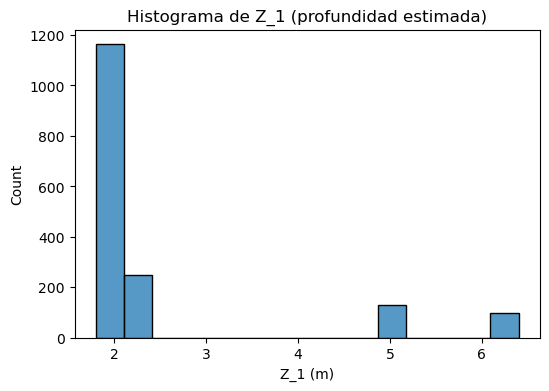

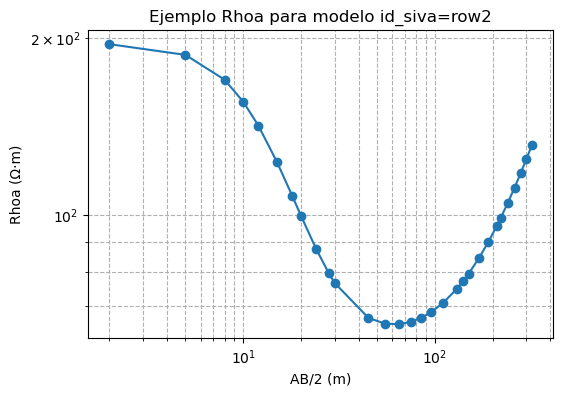

In [17]:
# -------------------------
# Verificaciones y gráficos básicos
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de Rhoa no nulos (por columna)
rhoa_counts = df[[f"Rhoa_{i+1}" for i in range(N_POINTS)]].notna().sum()
print("Valores no nulos por Rhoa_i:", rhoa_counts.values)

# Histograma de Z_1 (profundidad estimada para primer AB2)
plt.figure(figsize=(6,4))
sns.histplot(df["Z_1"].dropna(), bins=15)
plt.title("Histograma de Z_1 (profundidad estimada)")
plt.xlabel("Z_1 (m)")
plt.show()

# Mostrar una curva Rhoa (si hay datos)
if df["Rhoa_1"].notna().sum() > 0:
    # tomar primer registro con Rhoa no-nulos
    idx_sample = df[df["Rhoa_1"].notna()].index[0]
    rvals = [df.loc[idx_sample, f"Rhoa_{i+1}"] for i in range(N_POINTS)]
    ab2vals = [df.loc[idx_sample, f"AB2_{i+1}"] for i in range(N_POINTS)]
    # filtrar NaN
    ab2_plot = [a for a, r in zip(ab2vals, rvals) if not pd.isna(r)]
    r_plot = [r for r in rvals if not pd.isna(r)]
    plt.figure(figsize=(6,4))
    plt.loglog(ab2_plot, r_plot, marker='o')
    plt.xlabel("AB/2 (m)")
    plt.ylabel("Rhoa (Ω·m)")
    plt.title(f"Ejemplo Rhoa para modelo id_siva={df.loc[idx_sample,'id_siva']}")
    plt.grid(True, which="both", ls="--")
    plt.show()
else:
    print("No hay Rhoa calculados (PyGIMLi no disponible o modelos no válidos).")
